In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [26]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = 2023     # t_ref = T0_AB

e_B = 0.805
i_B = np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)
T0_B = 48707.5
P_B = 314.86
mean_B = np.radians(360*(t_ref - T0_B)/P_B)

e_A = 0.4808
i_A = np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)
T0_A = 48742.5
P_A = 264.51
mean_A = np.radians(360*(t_ref - T0_A)/P_A)

e_AB = 0.46
i_AB = np.radians(88.1)
a_AB = 51
m_A = 1.1
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)
T0_AB = 2023
P_AB = 230
mean_AB = np.radians(360*(t_ref - T0_AB)/P_AB)


# Disk parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disk = 0.03
pos_disk = np.radians(15.6)
inc_disk = np.radians(26)
omega_disk = np.radians(-73)
b_inner = a_inner*np.cos(inc_disk)*(1-e_disk**2)**0.5
b_outer = a_outer*np.cos(inc_disk)*(1-e_disk**2)**0.5

tau_disk = 1
fAa_i = 0.87                         # incident flux
fAa_t = fAa_i*np.exp(-tau_disk)      # transmitted flux of Aa during transit
fAb_i = 0.13                         # incident flux
fAb_t = fAb_i*np.exp(-tau_disk)      # transmitted flux of Ab during transit

In [3]:
# Build disk

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disk)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disk)

# Rotate disk
x_o = x_outer*np.cos(pos_disk) - y_outer*np.sin(pos_disk)
y_o = x_outer*np.sin(pos_disk) + y_outer*np.cos(pos_disk)
x_i = x_inner*np.cos(pos_disk) - y_inner*np.sin(pos_disk)
y_i = x_inner*np.sin(pos_disk) + y_inner*np.cos(pos_disk)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

In [4]:
# Create 3 star system - B + Aa + Ab

# Create system B (Ba + Bb)

sim2 = rebound.Simulation()
sim2.units = ('days', 'AU', 'Msun')

B = rebound.Particle(simulation=sim2,
                      m=m_B,
                     )



sim2.add(B)

# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim2,
                     primary=B,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB,
                     M=mean_AB
                    )

# Create system AaAb and shift to CoM reference frame

sim_A = rebound.Simulation()
sim_A.units = ('days', 'AU', 'Msun')
sim_A.move_to_hel()



Aa = rebound.Particle(simulation=sim_A,
                      m=m_Aa,
                     )

Ab = rebound.Particle(simulation=sim_A,
                      primary=Aa,
                      m=m_Ab,
                      a=a_A,
                      e=e_A,
                      omega=omega_Ab,
                      inc=i_A,
                      Omega=Omega_A,
                      M=mean_A
                     )


sim_A.add(Aa)
sim_A.add(Ab)
sim_A.move_to_com()
Aa_A, Ab_A = sim_A.particles      # Aa and Ab in the A CoM reference frame


# Shift Aa and Ab into the system B CoM reference frame

def change_reference_frames(star, ref):
    # ref = old reference frame in the new reference frame
    # star = star in the old reference frame
    ref_v = np.array([ref.vx, ref.vy, ref.vz])                            # velocity of current reference frame in the new reference frame
    v_in_ref = np.array([star.vx, star.vy, star.vz])                      # velocity of star in current reference frame
    v = v_in_ref + ref_v                                                  # velocity of star in the new reference frame
    
    ref_pos = np.array([ref.x, ref.y, ref.z])                             # position of current reference frame in the new reference frame
    pos_in_ref = np.array([star.x, star.y, star.z])                       # position of star in current reference frame
    pos = pos_in_ref + ref_pos                                            # position of star in the new reference frame
    
    return pos,v

pos_Aa, v_Aa = change_reference_frames(Aa_A, A)
pos_Ab, v_Ab = change_reference_frames(Ab_A, A)

def generate_cartesian_particle(m, pos, v):
    x, y, z = pos
    vx, vy, vz = v
    return rebound.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)

Aa = generate_cartesian_particle(m_Aa, pos_Aa, v_Aa)
Ab = generate_cartesian_particle(m_Ab, pos_Ab, v_Ab)

sim2.add(Aa)
sim2.add(Ab)
sim2.move_to_com()



In [27]:
# Plot orbits

start_time = 0
t_max = 18*365.25 + start_time   # integrate over 18 years
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_B, y_B, z_B = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)  
x_Aa, y_Aa, z_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Ab, y_Ab, z_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

vx_B, vy_B, vz_B= np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Aa, vy_Aa, vz_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ab, vy_Ab, vz_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)

B, Aa, Ab = sim2.particles

xa_transits = []
ya_transits = []

xb_transits = []
yb_transits = []

flux_Aa = np.zeros(n_steps)
flux_Ab = np.zeros(n_steps)

for i, t in enumerate(times):
    sim2.integrate(t)

    pos_B = np.array([B.x, B.y, B.z])
    v_B = np.array([B.vx, B.vy, B.vz])
    
    # Recenter all components so the B is at the origin
    x_Aa[i], y_Aa[i], z_Aa[i] = np.array([Aa.x, Aa.y, Aa.z]) - pos_B
    x_Ab[i], y_Ab[i], z_Ab[i] = np.array([Ab.x, Ab.y, Ab.z]) - pos_B
    vx_Aa[i], vy_Aa[i], vz_Aa[i] = np.array([Aa.vx, Aa.vy, Aa.vz]) - v_B
    vx_Ab[i], vy_Ab[i], vz_Ab[i] = np.array([Ab.vx, Ab.vy, Ab.vz]) - v_B
    
    x_B[i], y_B[i], z_B[i] = np.array([B.x, B.y, B.z]) - pos_B
    vx_B[i], vy_B[i], vz_B[i] = np.array([B.vx, B.vy, B.vz]) - v_B
    
    # Rotate disk and A to y=0 to determine when transit is happening     
    x_a, y_a = x_Aa[i], y_Aa[i]
    r_a = (x_a**2 + y_a**2)**0.5      # x_a=r, y_a=0 after rotation
    theta_a = np.arctan(y_a/x_a)

    x_b, y_b = x_Ab[i], y_Ab[i]
    r_b = (x_b**2 + y_b**2)**0.5      # x_a=r, y_a=0 after rotation
    theta_b = np.arctan(y_b/x_b)

    phi_a = pos_disk - theta_a    # effective arg of periapsis of disk (in relation to Aa)
    phi_b = pos_disk - theta_b    # effective arg of periapsis of disk (in relation to Ab)
    
    F_inner = (a_inner**2)*(b_inner**2)
    F_outer = (a_outer**2)*(b_outer**2)
    Aa_inner =  (a_inner**2)*(np.sin(phi_a)**2) + (b_inner**2)*(np.cos(phi_a)**2)
    Aa_outer =  (a_outer**2)*(np.sin(phi_a)**2) + (b_outer**2)*(np.cos(phi_a)**2)
    Ab_inner =  (a_inner**2)*(np.sin(phi_b)**2) + (b_inner**2)*(np.cos(phi_b)**2)
    Ab_outer =  (a_outer**2)*(np.sin(phi_b)**2) + (b_outer**2)*(np.cos(phi_b)**2) 
    
    xa_inner2 =  (F_inner/Aa_inner)**0.5
    xa_outer2 = (F_outer/Aa_outer)**0.5
    xb_inner2 =  (F_inner/Ab_inner)**0.5
    xb_outer2 = (F_outer/Ab_outer)**0.5


    if xa_inner2 < r_a < xa_outer2:
        xa_transits.append(x_Aa[i])
        ya_transits.append(y_Aa[i])
        flux_Aa[i] = fAa_t
    else:
        flux_Aa[i] = fAa_i

    if xb_inner2 < r_b < xb_outer2:
        xb_transits.append(x_Ab[i])
        yb_transits.append(y_Ab[i])
        flux_Ab[i] = fAb_t
    else:
        flux_Ab[i] = fAb_i

    
    

<IPython.core.display.Javascript object>


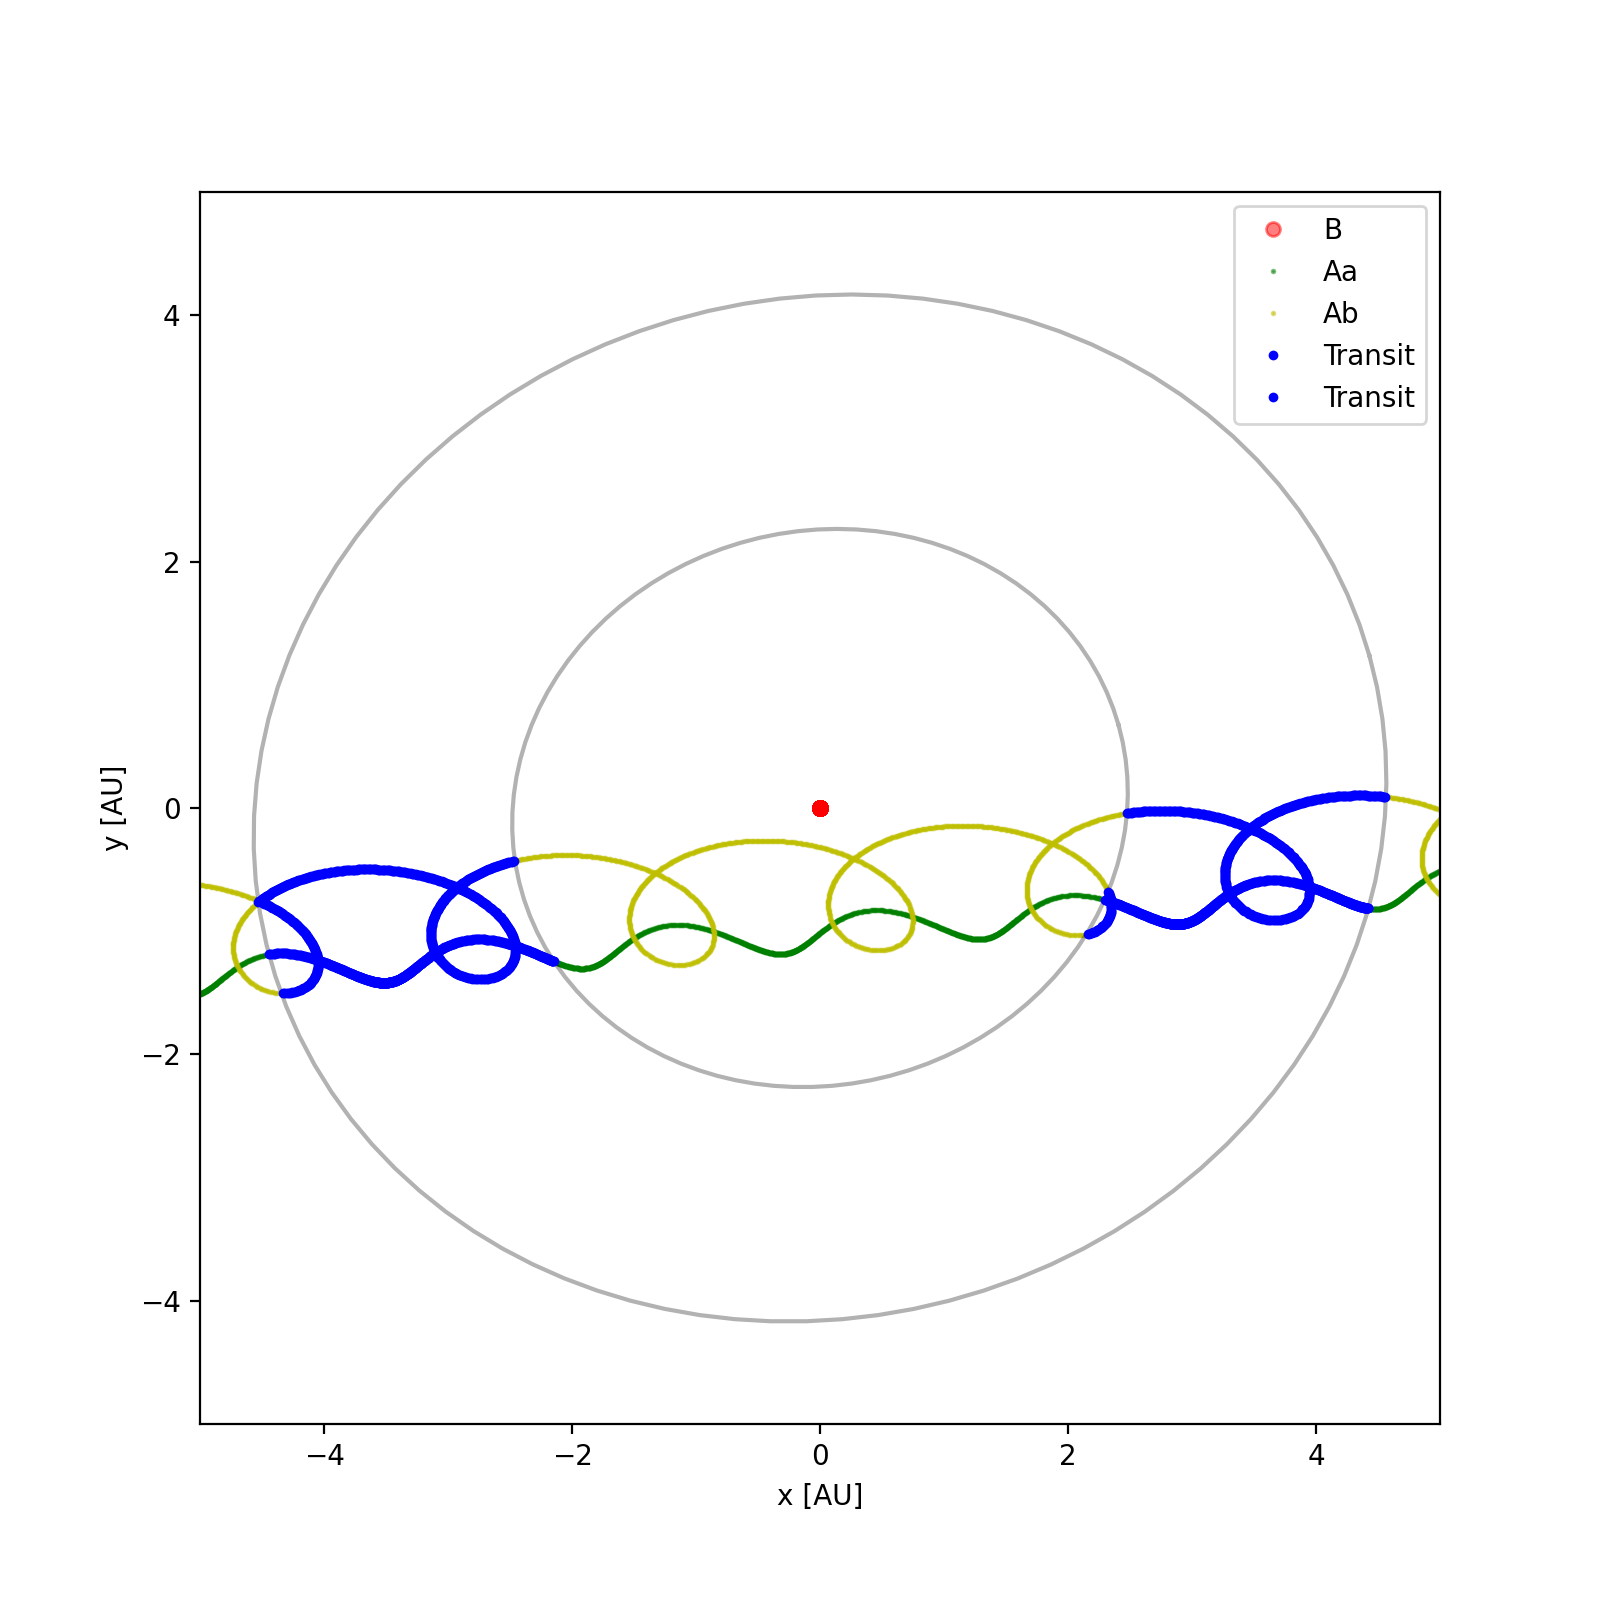

In [15]:
# Make 2D plot
fig1 = plt.figure(1, figsize=(8,8))

plt.plot(x_B, y_B, 'r.', alpha = 0.5, markersize=10, label='B', figure=fig1)
plt.plot(x_Aa, y_Aa, 'g.', alpha = 0.5, markersize=2, label='Aa', figure=fig1)
plt.plot(x_Ab, y_Ab, 'y.', alpha = 0.5, markersize=2, label='Ab', figure=fig1)

plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.plot(xa_transits, ya_transits, 'b.', markersize=5, label = 'Transit', figure=fig1)
plt.plot(xb_transits, yb_transits, 'b.', markersize=5, label = 'Transit', figure=fig1)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()

<IPython.core.display.Javascript object>


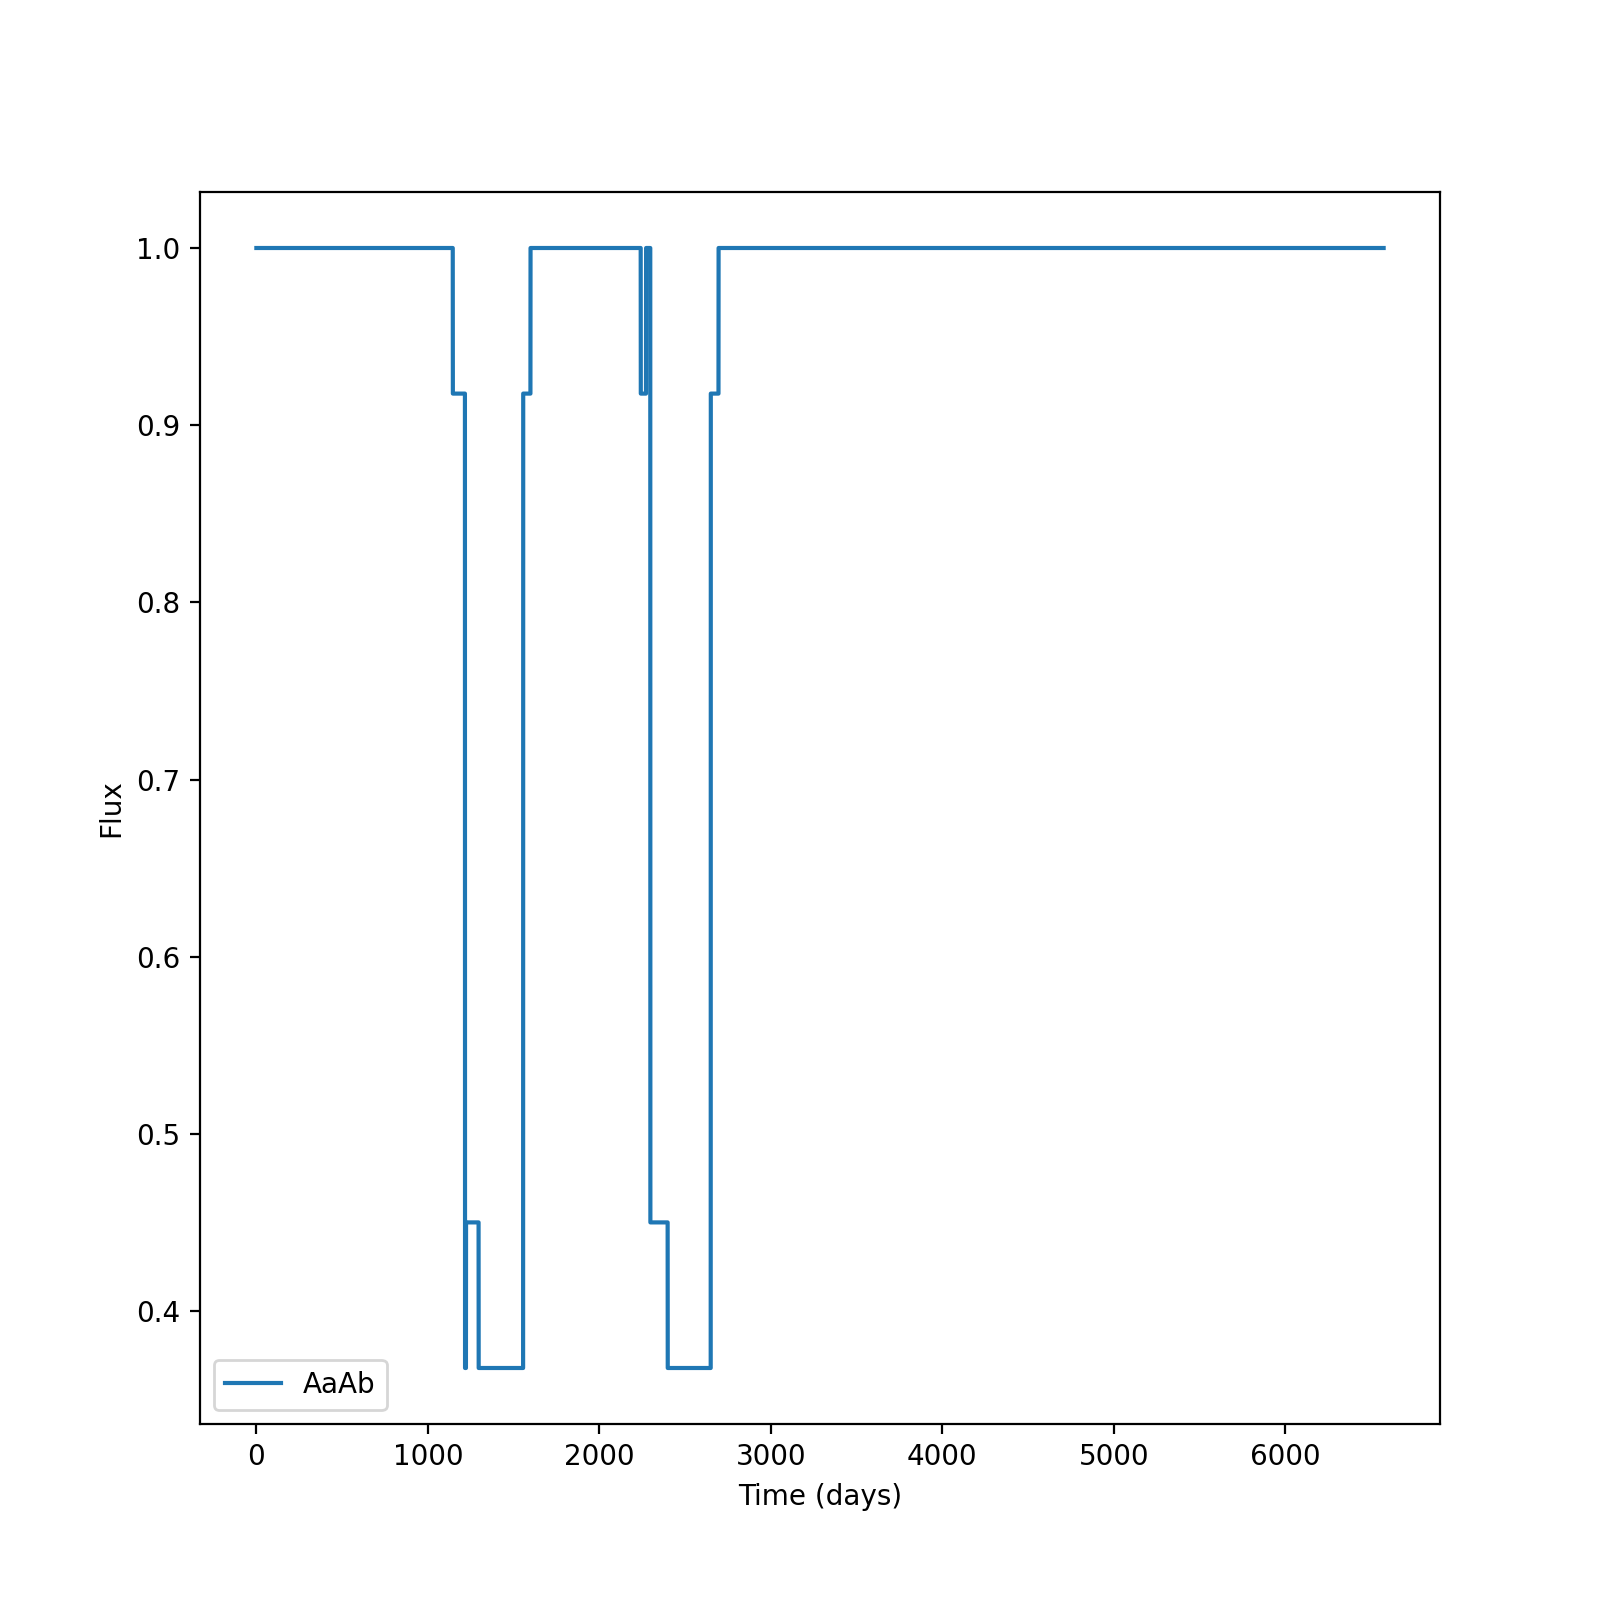

In [29]:
# Plot lightcurve during transit
fig2 = plt.figure(2, figsize=(8,8))

# plt.plot(times, flux_Aa, label = 'Aa', figure=fig2)
# plt.plot(times, flux_Ab, label = 'Ab', figure=fig2)
plt.plot(times, flux_Ab+flux_Aa, label = 'AaAb', figure=fig2)

plt.xlabel("Time (days)")
plt.ylabel("Flux")
# plt.xlim(0,6000)
# plt.ylim(0,)
plt.legend()
